<a href="https://colab.research.google.com/github/hollymandel/Mistral7B_Induction_Heads/blob/main/ih_sweep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Looking for Induction Heads in Mistral 7B**

This notebook uses the "head activation evaluators" from Olsson et al 2022 to locate induction heads in Mistral 7b.

In [ ]:
!pip install datasets
from datasets import load_dataset
dataset = load_dataset("facebook/babi_qa","en-10k-qa1",revision="main")

In [ ]:
!pip -q install transformers
!pip -q install bitsandbytes accelerate xformers einops # necessary for quantization

import torch
import transformers
import matplotlib.pyplot as plt
import random
import numpy as np
import pickle

In [ ]:
""" using a quantized and sharded version of Mistral 7B to fit on a single T4 """

bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16)

model_id = "Hugofernandez/Mistral-7B-v0.1-colab-sharded"
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    quantization_config = bnb_config,
    device_map = "auto",
    attn_implementation="eager")
tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)
start_token = tokenizer.bos_token
end_token = tokenizer.eos_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

In [5]:
MODEL_SIZE = 128
N_HEADS = 32
VOCAB_SIZE = 32000

""" hook wrappers """
def get_activation(storage):
  def hook(model, input, output):
      storage.append(output.detach())
  return hook

def get_attn(storage):
  def hook(model, input, output):
      storage.append(output[1].detach())
  return hook

def insert_ablation_hook(head_index):
  def hook(module, input, output):
      output[:,:,head_index*MODEL_SIZE:(head_index+1)*MODEL_SIZE].data.zero_()
  return hook


""" generate random sequence input data """
def rand_seq_gen(seq_len, repeats, start_token = 1, end_token = 2):
  # [start token] + ([random sequence] * n_repeats) + [end_token]
  exclude = {start_token, end_token}
  tokens = list(set(np.arange(tokenizer.vocab_size)) - exclude)
  return torch.tensor( [start_token] + random.sample(tokens, seq_len) * repeats + [end_token])


""" measure the copying behavior of each head via the direct path """
def direct_path(o_act, input_len):
  # unembed o_act -- "direct path"
  o_act_reshape = torch.permute(o_act.reshape([input_len + 2, N_HEADS,MODEL_SIZE]), [1,0,2,])
  unembed_reshape = torch.permute(model.lm_head._parameters["weight"].reshape([VOCAB_SIZE,N_HEADS,MODEL_SIZE]), [1,2,0,]) #32,128,3200
  return torch.matmul(o_act_reshape, unembed_reshape)

def direct_path_ratios(o_act, seq, diff=-1):
  # measure the relative effect of o_act on the logit for the token at position (current - diff). If
  # diff = 0 this is copying, if diff = -1 this is induction. Note that I do not rescale to -1, 1 as
  # in the paper
  seq_set = list(set(seq))[2:]
  logits = direct_path(o_act, len(seq)).cpu().detach().numpy()[:,1:-1,:]
  logits = logits - np.mean(logits,2)[:,:,None]
  raised_logits = logits * (logits > 0)
  raised_logits = raised_logits / np.sum(raised_logits[:,:,seq_set],2)[:,:,None]

  ratios_by_pos = []
  for i, x in enumerate(seq):
    if i >= diff and i < len(seq)+diff:
      ratios_by_pos.append(raised_logits[:,i+diff,x][:,None])

  return np.mean(np.concatenate(ratios_by_pos,1),1)


""" in a repeated sequence (token[1], token[2], ... , token[1], token[2],...), measure the
average attention from the LAST instance of token[i] to all PRIOR instances of token[i-offset]"""
def repeats_agg(this_attn, seq_len, n_repeats):
  # in a square block diagonal matrix with n_repeats blocks of size seq_len,
  # sum the first (n_repeats-1) column blocks of the last row block
  return sum(
      this_attn[-seq_len:,j*seq_len:(j+1)*seq_len]
      for j in range(n_repeats-1)
  )

def diag_score(attn_mat, offset, seq_len, n_repeats):
  # compute the average of the (offset) off diagonal sum of squares of the
  # attention matrix aggregated by repeats_agg. These diagonals wrap around
  # so they all have the same length.
  agg = repeats_agg(attn_mat, seq_len, n_repeats)
  attn_diag = sum(agg[i % seq_len,i - offset % seq_len]**2 for i in range(seq_len))
  all_norm = sum(agg[i,j]**2 for i in range(seq_len) for j in range(seq_len))
  return agg, attn_diag / all_norm, 1/seq_len

In [6]:
def sequence_repeat_ablation(ablation_layer, n_repeats = 4, seq_len = 25):
  """ this function performs an experiment on each head in layer `ablation_layers`. First, generate a random repeated
  sequence and compute the `loss_pre` (unablated loss). Then for each head measure the `copy_score` and `prefix_score`
  (as in the paper). These are the "head activation evaluators" defining induction heads in Olsson et al.
  Also measure the effect each head has on the logit for the next token using the direct path (`next_score`). Then
  ablate each head and measure the resulting loss (`ablation_losses`). These two last measurements should directly
  measure the head's contribution to induction, though perhaps not through the mechanism if the paper. """

  loss = torch.nn.CrossEntropyLoss()
  this_seq = rand_seq_gen(seq_len = seq_len, repeats = n_repeats)

  attns = []
  activations = []

  attn_hook = model.model.layers[ablation_layer].self_attn.register_forward_hook(get_attn(attns))
  emb_hook = model.model.layers[ablation_layer].self_attn.o_proj.register_forward_hook(get_activation(activations))

  # head statistics and pre-ablation loss
  try:
    output = model.forward(this_seq[None,:], output_attentions=True);
    loss_pre = loss(output["logits"][:,:-1,:].permute(0,2,1), this_seq[None,1:]).detach()

    copy_score = direct_path_ratios(activations[0], this_seq[1:-1].detach().numpy(),0)
    prefix_score = np.zeros([32])
    for j in range(32):
      this_attn = attns[0][0,j,1:-1,1:-1].to('cpu').detach().numpy() # remove start and end tokens
      _, this_score, _ = diag_score(this_attn, -1, seq_len, n_repeats) # normalized by total sum of squares
      prefix_score[j] = this_score

    next_score = direct_path_ratios(activations[0], this_seq[1:-1].detach().numpy(),-1)

  finally:
    attn_hook.remove()
    emb_hook.remove()
    torch.cuda.empty_cache()

  # post-ablation loss
  ablation_losses = {}
  for j in range(32):
    ablation_hook = model.model.layers[ablation_layer].post_attention_layernorm.register_forward_hook(insert_ablation_hook(j))

    try:
      output = model.forward(this_seq[None,:], output_attentions=True);
      ablation_losses[j] = loss(output["logits"][:,:-1,:].permute(0,2,1), this_seq[None,1:]).detach().numpy().item()

    finally:
      ablation_hook.remove()
      torch.cuda.empty_cache()

  return (
      loss_pre, ablation_losses,
      copy_score, next_score, prefix_score
  )

In [7]:
spacing = 4
layers_measure = np.arange(spacing-1,N_HEADS,spacing)
print(f"layers to measure: {layers_measure}")
n_repeats = 10

# all_outs = {layer: [] for layer in layers_measure}
# for layer in layers_measure:
#   for i in range(n_repeats):
#     all_outs[layer].append(sequence_repeat_ablation(layer, 4, 25))
#     print(f"completed loop {i} for layer {layer}")
#   with open(f"intermediate_layer{layer}.pkl", "wb") as f:
#     pickle.dump(all_outs[layer], f)
#   print(f"saved intermediate results for layer {layer}")

# import pickle
# with open("all_outs.pkl", "wb") as f:
#   pickle.dump(all_outs, f)

with open("all_outs.pkl", "rb") as f:
  all_outs = pickle.load(f)

layers to measure: [ 3  7 11 15 19 23 27 31]


In [8]:
def cat_repeats(out_list):
  cat_loss = np.asarray([out[0] for out in out_list])[None,:]
  cat_ablated = np.concatenate([np.asarray(list(out[1].values()))[:,None] for out in out_list ], 1)
  cat_copy = np.concatenate([out[2][:,None] for out in out_list ], 1)
  cat_next = np.concatenate([out[3][:,None] for out in out_list ], 1)
  cat_prefix = np.concatenate([out[4][:,None] for out in out_list], 1)
  return cat_loss, cat_ablated, cat_copy, cat_next, cat_prefix

cat_trials = { key: cat_repeats(value) for key, value in all_outs.items() }
cat_layers = [ np.concatenate([value[i][:,:,None] for value in cat_trials.values()],-1) for i in range(5)] # head, trial, layer

loss_pre = np.mean(cat_layers[0],1)
ablation_loss = np.mean(cat_layers[1],1)
copy_score = np.mean(cat_layers[2],1)
next_score = np.mean(cat_layers[3],1)
prefix_score = np.mean(cat_layers[4],1)

Text(0, 0.5, 'copy score')

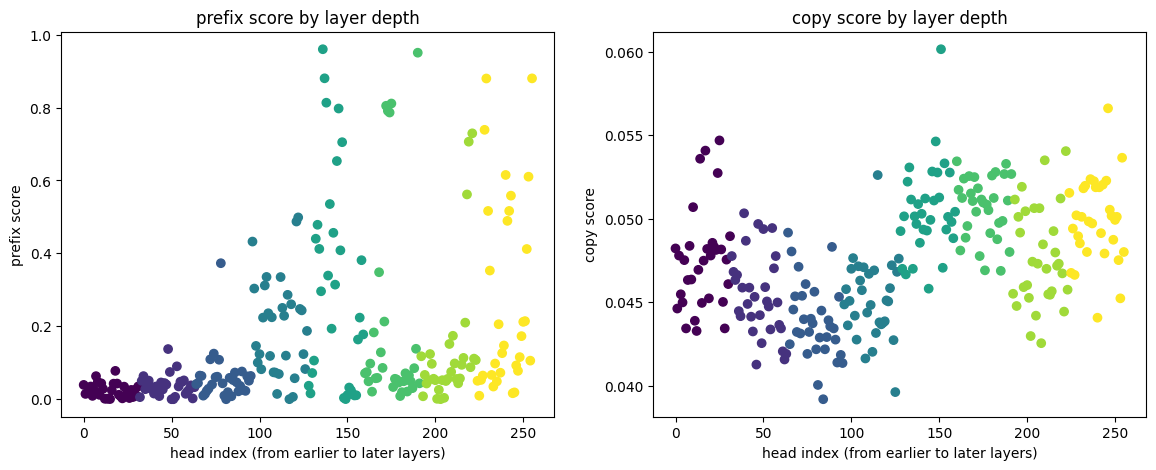

In [9]:
# prefix score versus layer depth (See appendix,  section "Where induction heads form")

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = [14,5])

x = np.arange(32*8)
y = np.ravel(prefix_score,"F")
c = np.repeat(layers_measure,32)
axs[0].scatter(x, y, c=c)
axs[0].set_title("prefix score by layer depth")
axs[0].set_xlabel("head index (from earlier to later layers)")
axs[0].set_ylabel("prefix score")

y = np.ravel(copy_score,"F")
axs[1].scatter(x, y, c=c)
axs[1].set_title("copy score by layer depth")
axs[1].set_xlabel("head index (from earlier to later layers)")
axs[1].set_ylabel("copy score")

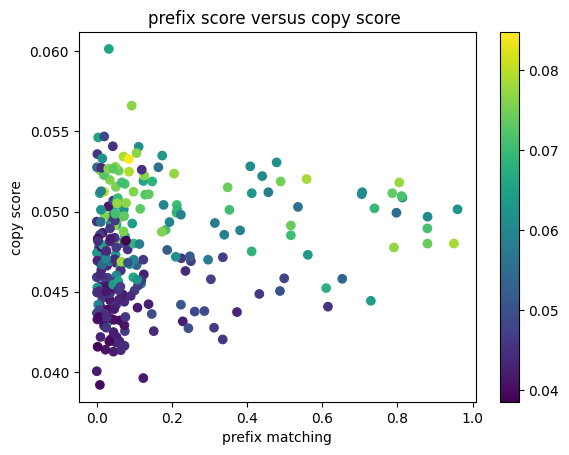

In [10]:
# Prefix score versus copy score (see appendix, section "Distribution of scores")
# color corresponds to next token score, a more direct (but less "mechanistic") measure of induction

plt.scatter(np.ravel(prefix_score), np.ravel(copy_score), c=np.ravel(next_score))
plt.xlabel("prefix matching")
plt.ylabel("copy score")
plt.title("prefix score versus copy score ")
plt.colorbar()

In [11]:
# pick out most and least induction-head-y heads, ablation for in context learning
# this is not in the paper (I think), but I am just using the x == y direction on the above plot to pick out the most-
# and least- induction-head-y heads

def induction_score_function(prefix_score, copy_score):
  copy_score_rescale = lambda x: (x - 0.035) / 0.02
  return np.sqrt(prefix_score**2 + copy_score_rescale(copy_score)**2)

induction_score = induction_score_function(prefix_score, copy_score)

In [12]:
import scipy.stats as scs

scs.linregress(induction_score.ravel(),next_score.ravel())

LinregressResult(slope=0.040661951950412514, intercept=0.028475381411422782, rvalue=0.668664766985636, pvalue=1.5370108886314058e-34, stderr=0.0028371433676142943, intercept_stderr=0.0019974462530884846)

In [13]:
import re
import numpy as np



PROMPT_HEADER = "Read the following passage and answer the questions with a single word.\n\n"
# PROMPT_HEADER = "Here is a passage and answered questions. It is a training dataset for an ML model.\n\n"

def create_prompt(story, header = PROMPT_HEADER, start = 0, end = np.infty):

  prompt = header
  lines = list(zip(story["text"], story["answer"]))
  for i, (text, answer) in enumerate(zip(story["text"], story["answer"])):
    top = min(len(story["text"]),end)
    if i < start or i >= end:
      continue
    if (i+1) % 3 != 0:
      if (i+1) % 3 == 1:
        prompt += "Passage: "
      prompt += f"{text}\n"
    else:
      prompt += "\nQuestion: " + f"{text}\n"
      prompt += "Answer: "
      if i != top-1:
        prompt += f"{answer}\n"

  return prompt

def score_model(story, margin = 3, verbose = 0, start = 0, end = np.infty):
  if end == np.infty:
    end = len(story["id"])
  prompt = create_prompt(story, start = start, end = end)
  prompt_encode = tokenizer.encode(prompt, return_tensors = "pt", padding=True, truncation=True)

  prompt_len = len(prompt_encode[0])
  output = model.generate(prompt_encode, max_length=prompt_len + margin, num_return_sequences=1, pad_token_id=tokenizer.eos_token_id)
  # output = modified_generate(model, prompt_encode, margin)

  decode = tokenizer.decode(output[0][prompt_len:], padding=True, return_tensors="pt", truncation=True)
  parsed = re.findall(r'\w+', decode)

  if verbose >= 2:
    print(prompt)
  if verbose >= 1:
    print(parsed)
    print(f"desired: {story['answer'][end-1]}")
    # print(output[0][prompt_len:])
    # print(decode)

  if story["answer"][end-1] in parsed:
    return True
  return False


In [19]:
type(dataset["train"]["story"])

list

In [ ]:
# prompt = create_prompt(story)
# prompt_encode = tokenizer.encode(prompt, return_tensors = "pt", padding=True, truncation=True)

win = 0
lose = 0
for story in dataset["train"]["story"]:
  if score_model(story,verbose=0,end=np.infty):
    win += 1
  else:
    lose += 1
  print(f"score: {win}/{win+lose}")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1510: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


score: 0/1
score: 1/2
score: 2/3
score: 3/4
score: 4/5
score: 5/6
score: 6/7
score: 6/8
score: 6/9
score: 7/10
score: 8/11
score: 8/12


In [51]:
dataset

NameError: name 'dataset' is not defined